'model/MiDaS_small.xml' already exists.
'model/MiDaS_small.bin' already exists.
0
2
0
0
405
0
1
0
1
0
1
0
1
183
140
139
140
148
142
142
143
144
141
146
149
0
230
165
2
164
256
0
155
0
157
0
154
0
0
250
143
247
0
240
0
237
0
132
237
0
0
0
0
128
0
125
0
132
0
0
235
150
0
222
0
146
218
123
0
220
127
0
124
213
0
212
127
0
215
123
0
215
123
0
129
0
218
126
0
127
0
221
141
222
125
0
212
141
0
212
141
0
125
215
0
231
123
0
209
124
0
216
120
0
225
120
0
216
121
0
223
125
0
221
124
0
121
236
0
118
233
0
226
120
1
118
220
1
128
227
0
128
227
0
128
227
0
115
1
126
0
126
0
116
209
1
208
116
0
118
0
120
229
114
225
115
220
115
220
115
242
119
242
119
120
225
119
122
124
206
201
117
198
117
200
113
198
115
115
215
115
206
118
221
115
216
124
216
124
220
114
220
114
219
114
211
117
220
115
220
115
124
214
220
115
220
115
224
115
224
115
114
227
113
227
113
227
227
226
115
226
115
233
123
233
123
234
113
234
113
117
117
118
226


/tmp/ipykernel_25848/2151632308.py:315: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(colormap)


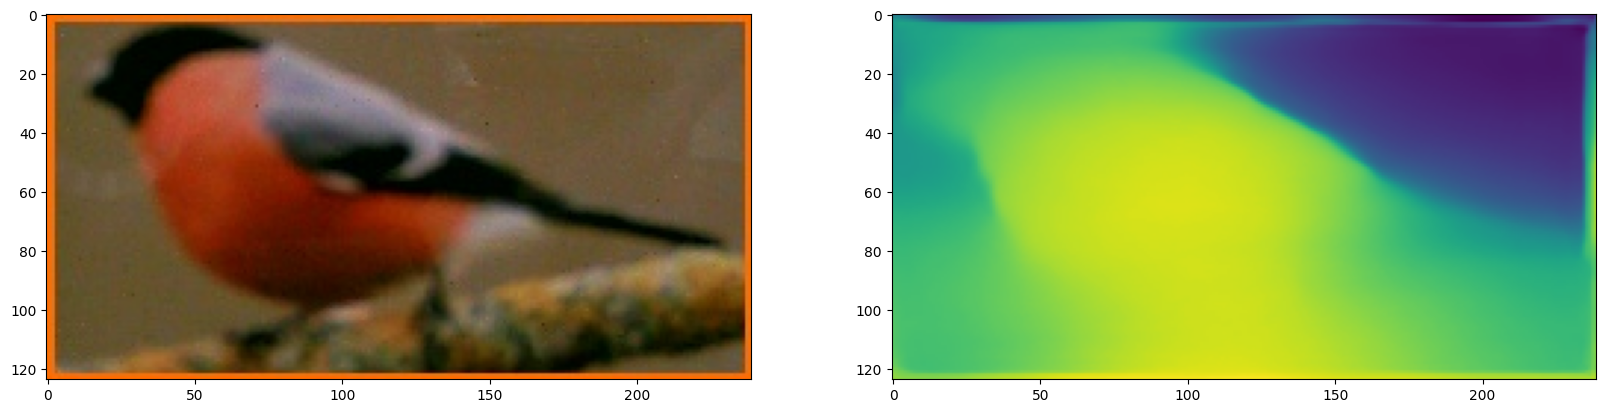

In [14]:
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
    
import collections
import tarfile
import time
from pathlib import Path

import cv2
import numpy as np
from IPython import display
import openvino as ov
from openvino.tools.mo.front import tf as ov_tf_front
from openvino.tools import mo

import notebook_utils as utils

import matplotlib.cm
import matplotlib.pyplot as plt
from IPython.display import (
    HTML,
    FileLink,
    Pretty,
    ProgressBar,
    Video,
    clear_output,
    display,
)
from notebook_utils import download_file, load_image

# A directory where the model will be downloaded.
base_model_dir = Path("model")

# The name of the model from Open Model Zoo
model_name = "ssdlite_mobilenet_v2"

archive_name = Path(f"{model_name}_coco_2018_05_09.tar.gz")
model_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/public/2022.1/{model_name}/{archive_name}"

# Download the archive
downloaded_model_path = base_model_dir / archive_name
if not downloaded_model_path.exists():
    utils.download_file(model_url, downloaded_model_path.name, downloaded_model_path.parent)

# Unpack the model
tf_model_path = base_model_dir / archive_name.with_suffix("").stem / "frozen_inference_graph.pb"
if not tf_model_path.exists():
    with tarfile.open(downloaded_model_path) as file:
        file.extractall(base_model_dir)
        
precision = "FP16"
# The output path for the conversion.
converted_model_path = Path("model") / f"{model_name}_{precision.lower()}.xml"

# Convert it to IR if not previously converted
trans_config_path = Path(ov_tf_front.__file__).parent / "ssd_v2_support.json"
if not converted_model_path.exists():
    ov_model = mo.convert_model(
        tf_model_path, 
        compress_to_fp16=(precision == 'FP16'), 
        transformations_config=trans_config_path,
        tensorflow_object_detection_api_pipeline_config=tf_model_path.parent / "pipeline.config", 
        reverse_input_channels=True
    )
    ov.save_model(ov_model, converted_model_path)
    del ov_model
    
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

# Read the network and corresponding weights from a file.
model = core.read_model(model=converted_model_path)
# Compile the model for CPU (you can choose manually CPU, GPU etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = core.compile_model(model=model, device_name=device.value)

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# Get the input size.
height, width = list(input_layer.shape)[1:3]

input_layer.any_name, output_layer.any_name

model_folder = Path('model')

ir_model_url = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/depth-estimation-midas/FP32/'
ir_model_name_xml = 'MiDaS_small.xml'
ir_model_name_bin = 'MiDaS_small.bin'

download_file(ir_model_url + ir_model_name_xml, filename=ir_model_name_xml, directory=model_folder)
download_file(ir_model_url + ir_model_name_bin, filename=ir_model_name_bin, directory=model_folder)

model_xml_path = model_folder / ir_model_name_xml

# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
classes = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet",
    "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush",'tree'
]

# Colors for the classes above (Rainbow Color Map).
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()

def process_results(frame, results, thresh=0.6):
    # The size of the original frame.
    h, w = frame.shape[:2]
    # The 'results' variable is a [1, 1, 100, 7] tensor.
    results = results.squeeze()
    boxes = []
    labels = []
    scores = []
    for _, label, score, xmin, ymin, xmax, ymax in results:
        
        boxes.append(
            tuple(map(int, (xmin * w, ymin * h, (xmax - xmin) * w, (ymax - ymin) * h)))
        )
        labels.append(int(label))
        scores.append(float(score))

    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=thresh, nms_threshold=0.6
    )

    if len(indices) == 0:
        
        return []

    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]


def draw_boxes(frame, boxes):
    i = 0
    for label, score, box in boxes:
        # Choose color for the label.
        color = tuple(map(int, colors[label]))
        # Draw a box.
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        rgb_image = cv2.rectangle(img=frame, pt1=box[:2], pt2=(x2, y2), color=color, thickness=3)
        print(box[:2][0])
        a_image = rgb_image[box[:2][1]:y2, box[:2][0]:x2]
        cv2.imwrite(f'./image/{label}.jpg', a_image)
        i+=1
        # Draw a label name inside the box.
        cv2.putText(
            img=frame,
            text=f"{classes[label]} {score:.2f}",
            org=(box[0] + 10, box[1] + 30),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame.shape[1] / 1000,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

    return frame

# Main processing function to run object detection.

def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Resize the image and change dims to fit neural network input.
            input_img = cv2.resize(
                src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA
            )
            # Create a batch of images (size = 1).
            input_img = input_img[np.newaxis, ...]

            # Measure processing time.

            start_time = time.time()
            # Get the results.
            results = compiled_model([input_img])[output_layer]
            stop_time = time.time()
            # Get poses from network results.
            boxes = process_results(frame=frame, results=results)

            # Draw boxes on a frame.
            frame = draw_boxes(frame=frame, boxes=boxes)
            
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()
            
USE_WEBCAM = True

#video_file = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"
video_file = "401-object-detection.gif"
cam_id = 0

source = cam_id if USE_WEBCAM else video_file


run_object_detection(source=source, flip=isinstance(source, int), use_popup=True)

def normalize_minmax(data):
    """Normalizes the values in `data` between 0 and 1"""
    return (data - data.min()) / (data.max() - data.min())


def convert_result_to_image(result, colormap="viridis"):
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    `result` is expected to be a single network result in 1,H,W shape
    `colormap` is a matplotlib colormap.
    See https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    cmap = matplotlib.cm.get_cmap(colormap)
    result = result.squeeze(0)
    result = normalize_minmax(result)
    result = cmap(result)[:, :, :3] * 255
    result = result.astype(np.uint8)
    return result


def to_rgb(image_data) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

core = ov.Core()
core.set_property({'CACHE_DIR': '../cache'})
model = core.read_model(model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

input_key = compiled_model.input(0)
output_key = compiled_model.output(0)

network_input_shape = list(input_key.shape)
network_image_height, network_image_width = network_input_shape[2:]

IMAGE_FILE = "./image/16.jpg"
image = load_image(path=IMAGE_FILE)

#print(image.shape())
try:
    resized_image = cv2.resize(src=image, dsize=(network_image_height, network_image_width))
    input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)
    result = compiled_model([input_image])[output_key]
    result_image = convert_result_to_image(result=result)
    result_image = cv2.resize(result_image, image.shape[:2][::-1])
except Exception as e:
    print(str(e))
    

fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(to_rgb(image))
ax[1].imshow(result_image)

#a = cv2.cvtColor(result_image,cv2.COLOR_BGR2RGB)
#print(a)
